# Exemple sur le modèle jouet Campbell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gpflow

2025-12-08 10:59:35.942077: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 10:59:36.544163: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 10:59:38.889988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 10:59:38.893063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 10:59:45.466442: W tensorflow/compiler/tf2t

In [2]:
%reload_ext autoreload
%autoreload 2

import model_class

On récupère les entrées

In [7]:
hs_list = np.arange(1, 3.1, 0.5)
msl_list = np.arange(0, 1.1, 0.1)

x_train = np.array([[hs, msl] for hs in hs_list for msl in msl_list])

remove_points = np.array([
    [2., 0.2],
    [2.5, 0.5],
    [1.5, 0.6],
    [2., 0.8],
    [1., 1.]
])

to_remove = np.zeros(len(x_train), dtype=bool)
for rp in remove_points:
    # np.isclose compare élément par élément ; on prend toutes les colonnes avec all(axis=1)
    to_remove |= np.all(np.isclose(x_train, rp, atol=1e-8), axis=1)

x_train_filtered = x_train[~to_remove]

print("avant :", x_train.shape)       # (55, 2)
print("après  :", x_train_filtered.shape)  # (50, 2)
print(x_train_filtered)

avant : (55, 2)
après  : (50, 2)
[[1.  0. ]
 [1.  0.1]
 [1.  0.2]
 [1.  0.3]
 [1.  0.4]
 [1.  0.5]
 [1.  0.6]
 [1.  0.7]
 [1.  0.8]
 [1.  0.9]
 [1.5 0. ]
 [1.5 0.1]
 [1.5 0.2]
 [1.5 0.3]
 [1.5 0.4]
 [1.5 0.5]
 [1.5 0.7]
 [1.5 0.8]
 [1.5 0.9]
 [1.5 1. ]
 [2.  0. ]
 [2.  0.1]
 [2.  0.3]
 [2.  0.4]
 [2.  0.5]
 [2.  0.6]
 [2.  0.7]
 [2.  0.9]
 [2.  1. ]
 [2.5 0. ]
 [2.5 0.1]
 [2.5 0.2]
 [2.5 0.3]
 [2.5 0.4]
 [2.5 0.6]
 [2.5 0.7]
 [2.5 0.8]
 [2.5 0.9]
 [2.5 1. ]
 [3.  0. ]
 [3.  0.1]
 [3.  0.2]
 [3.  0.3]
 [3.  0.4]
 [3.  0.5]
 [3.  0.6]
 [3.  0.7]
 [3.  0.8]
 [3.  0.9]
 [3.  1. ]]


In [8]:
x_test = np.array([[2,0.2],[2.5,0.5],[1.5,0.6],[2,0.8],[1,1]])

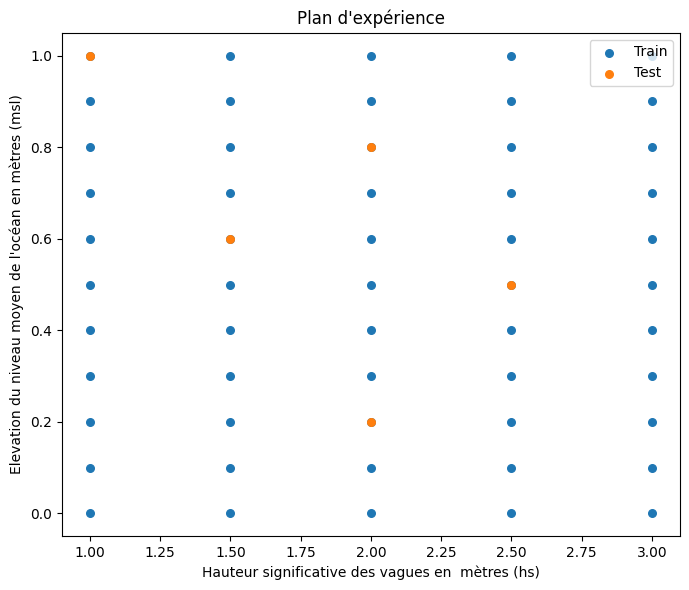

In [9]:
plt.figure(figsize=(7,6))
plt.scatter(x_train[:,0],x_train[:,1],label="Train",s=30)
plt.scatter(x_test[:,0],x_test[:,1],label="Test",s=30)
plt.xlabel("Hauteur significative des vagues en  mètres (hs)")
plt.ylabel("Elevation du niveau moyen de l'océan en mètres (msl)")
plt.title("Plan d'expérience")
plt.legend()
plt.tight_layout()
plt.show()

Train

In [13]:
x_train_filtered

array([[1. , 0. ],
       [1. , 0.1],
       [1. , 0.2],
       [1. , 0.3],
       [1. , 0.4],
       [1. , 0.5],
       [1. , 0.6],
       [1. , 0.7],
       [1. , 0.8],
       [1. , 0.9],
       [1.5, 0. ],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.5, 0.3],
       [1.5, 0.4],
       [1.5, 0.5],
       [1.5, 0.7],
       [1.5, 0.8],
       [1.5, 0.9],
       [1.5, 1. ],
       [2. , 0. ],
       [2. , 0.1],
       [2. , 0.3],
       [2. , 0.4],
       [2. , 0.5],
       [2. , 0.6],
       [2. , 0.7],
       [2. , 0.9],
       [2. , 1. ],
       [2.5, 0. ],
       [2.5, 0.1],
       [2.5, 0.2],
       [2.5, 0.3],
       [2.5, 0.4],
       [2.5, 0.6],
       [2.5, 0.7],
       [2.5, 0.8],
       [2.5, 0.9],
       [2.5, 1. ],
       [3. , 0. ],
       [3. , 0.1],
       [3. , 0.2],
       [3. , 0.3],
       [3. , 0.4],
       [3. , 0.5],
       [3. , 0.6],
       [3. , 0.7],
       [3. , 0.8],
       [3. , 0.9],
       [3. , 1. ]])

In [50]:
base_folder = "data_malo_GP/Train"

# On récupère le nombre de cellules terrestres
cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",
                        dtype=">f8").reshape(-1, 5)
n_cells = cell_info.shape[0]
id_gmsh = cell_info[:, 0].astype(int)-1  

y_train_H_max = []
y_train_H_moyenne = []

for hs,msl in x_train_filtered:

        folder_name = f"run_msl_{msl:.1f}_hs_{hs:.1f}"
        file_path = os.path.join(base_folder, folder_name, "scattered_map_final.bin")

        if not os.path.exists(file_path):
            print("⚠️ Fichier manquant :", file_path)
            Hmax = np.full(n_cells, np.nan)
            Hmoyenne = np.full(n_cells, np.nan)
        else:
            # Lecture correcte du binaire (big-endian float64)
            data = np.fromfile(file_path, dtype=">f8").reshape(-1, 3)

            # Colonnes : [ID_global, Hmax_T, Hmean_T]
            Hmax = data[:, 1]   # Hauteur max
            Hmoyenne = data[:, 2]  # Hauteur moyenne

        y_train_H_max.append(Hmax)
        y_train_H_moyenne.append(Hmoyenne)
y_train_Hmax = np.array(y_train_H_max)
y_train_H_moyenne = np.array(y_train_H_moyenne)

print("Taille de y_train_Hmax :", y_train_Hmax.shape)
print("Taille de y_train_H_moyenne :", y_train_H_moyenne.shape)

Taille de y_train_Hmax : (50, 488290)
Taille de y_train_H_moyenne : (50, 488290)


Test

In [ ]:
base_folder = "data_malo_GP/Test"

# On récupère le nombre de cellules terrestres
cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",
                        dtype=">f8").reshape(-1, 5)
n_cells = cell_info.shape[0]

y_test_Hmax = []
y_test_H_moyenne = []

for hs,msl in x_test:
        folder_name = f"run_msl_{msl:.1f}_hs_{hs:.1f}"
        file_path = os.path.join(base_folder, folder_name, "scattered_map_final.bin")

        if not os.path.exists(file_path):
            print("⚠️ Fichier manquant :", file_path)
            Hmax = np.full(n_cells, np.nan)
            Hmoyenne = np.full(n_cells, np.nan)
        else:
            # Lecture correcte du binaire (big-endian float64)
            data = np.fromfile(file_path, dtype=">f8").reshape(-1, 3)

            # Colonnes : [ID_global, Hmax_T, Hmean_T]
            Hmax = data[:, 1]   # Hauteur max
            Hmoyenne = data[:, 2]  # Hauteur moyenne
            
        y_test_Hmax.append(Hmax)
        y_test_H_moyenne.append(Hmoyenne)
        
y_test_Hmax = np.array(y_test_Hmax)
y_test_H_moyenne = np.array(y_test_H_moyenne)

print("Taille de y_test_Hmax :", y_test_Hmax.shape)
print("Taille de y_test_H_moyenne :", y_test_H_moyenne.shape)

Taille de y_test_Hmax : (5, 488290)
Taille de y_test_H_moyenne : (5, 488290)


In [30]:
for y in [y_train_Hmax,y_train_H_moyenne]:
    print("type:",y.dtype)
    print("Présence de NaN:",np.isnan(y).any())
    print("Présence d'infini:",np.isinf(y).any())
    print("min =", np.nanmin(y))
    print("max =", np.nanmax(y))
    print("mean =", np.nanmean(y))
    print("std =", np.nanstd(y))

type: float64
Présence de NaN: False
Présence d'infini: False
min = 0.0
max = 12.982820152414803
mean = 0.4292753692213283
std = 0.8466257711298243
type: float64
Présence de NaN: False
Présence d'infini: False
min = 0.0
max = 10.610930827498573
mean = 0.21523176905124938
std = 0.7519922044490638


In [37]:
y_train = y_train_Hmax #y_train_H_moyenne
y_test = y_test_H_max #y_test_H_moyenne

In [32]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma
param = [theta, sigma]

kernel = gpflow.kernels.SquaredExponential(lengthscales=param[0], variance=param[1]**2) + gpflow.kernels.White(variance=1e-6)

2025-12-08 11:21:39.080859: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [36]:
# ACP ondelettes
ACP_wave = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p=0.9999,J=2)
ACP_wave.train(x_train_filtered,y_train,kernel_fn=kernel,verbose=True)

Nombre de coefficients conservés pour l'ACP : 218002

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée 

Bon bah ça à l'air de fonctionner, maintenant on peut voir ce que ca donne

In [42]:
Y_train_reconstruct_ACP_wave = ACP_wave.predict(x_train_filtered)  # On prédit sur les données d'entraînement pour vérifier la reconstruction

mse_ACP = np.mean((y_train - Y_train_reconstruct_ACP_wave)**2)
print("MSE ACP sur données d'entraînement :", mse_ACP)

Prédiction en cours...
MSE ACP sur données d'entraînement : 0.31677120902801953


In [43]:
Y_test_reconstruct_ACP_wave = ACP_wave.predict(x_test)  

mse_ACP = np.mean((y_test - Y_test_reconstruct_ACP_wave)**2)
print("MSE ACP sur données de test :", mse_ACP)

Prédiction en cours...
MSE ACP sur données de test : 0.10533792333592508


In [ ]:
    # Créer un array avec les hauteurs d'eau réélle en mappant correctement sur la carte
    map_true = np.full(mesh.n_cells, np.nan)
    map_true[id_vtk] = H_true
    mesh.cell_data["H_true"] = map_true
    #Hauteur d'eau prédite
    map_pred = np.full(mesh.n_cells, np.nan)
    map_pred[id_vtk] = H_pred
    mesh.cell_data["H_pred"] = map_pred

(5, 488290)

In [72]:
import pyvista as pv
def plot_map(H_true,H_pred):
    
    #Récupération du mapping entre le mesh et la carte
    mesh = pv.read("data_malo_GP/gmsh_mapping.vtk")
    cell_info = np.fromfile("data_malo_GP/scattered_land_data.bin",
                        dtype=">f8").reshape(-1, 5)
    id_gmsh = cell_info[:, 0].astype(int)-1  
    
    # vtk_2_gmsh[id_vtk] <--> id_gmsh                gmsh_2_vtk[id_gmsh] <--> id_vtk
    vtk_2_gmsh = mesh.cell_data["gmsh_cell_id"].astype(int)-1            # Convert to 0 based array
    gmsh_2_vtk = np.empty_like(vtk_2_gmsh)
    gmsh_2_vtk[vtk_2_gmsh] = np.arange(len(vtk_2_gmsh))
    id_vtk = gmsh_2_vtk[id_gmsh]


    submesh = mesh.extract_cells(id_vtk)
    # 1. Maillage pour l'affichage Vrai (Clone)
    mesh_true = submesh.copy()
    mesh_true.cell_data["H"] = H_true 
    
    # 2. Maillage pour l'affichage Prédit (Clone)
    mesh_pred = submesh.copy()
    mesh_pred.cell_data["H"] = H_pred

    #Plot
    plotter = pv.Plotter(shape=(1,2))
    plotter.subplot(0,0)
    plotter.add_mesh(mesh_true, scalars="H", clim=[0,1], cmap="coolwarm")
    plotter.view_xy()
    plotter.add_title("Sortie réelle",font_size=12)
    plotter.subplot(0,1)
    plotter.add_mesh(mesh_pred, scalars="H", clim=[0,1], cmap="coolwarm")
    plotter.view_xy()
    plotter.add_title("Reconstruction du métamodèle",font_size=12)
    
    
    plotter.show()

/home/slisse/.conda/envs/PIR/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


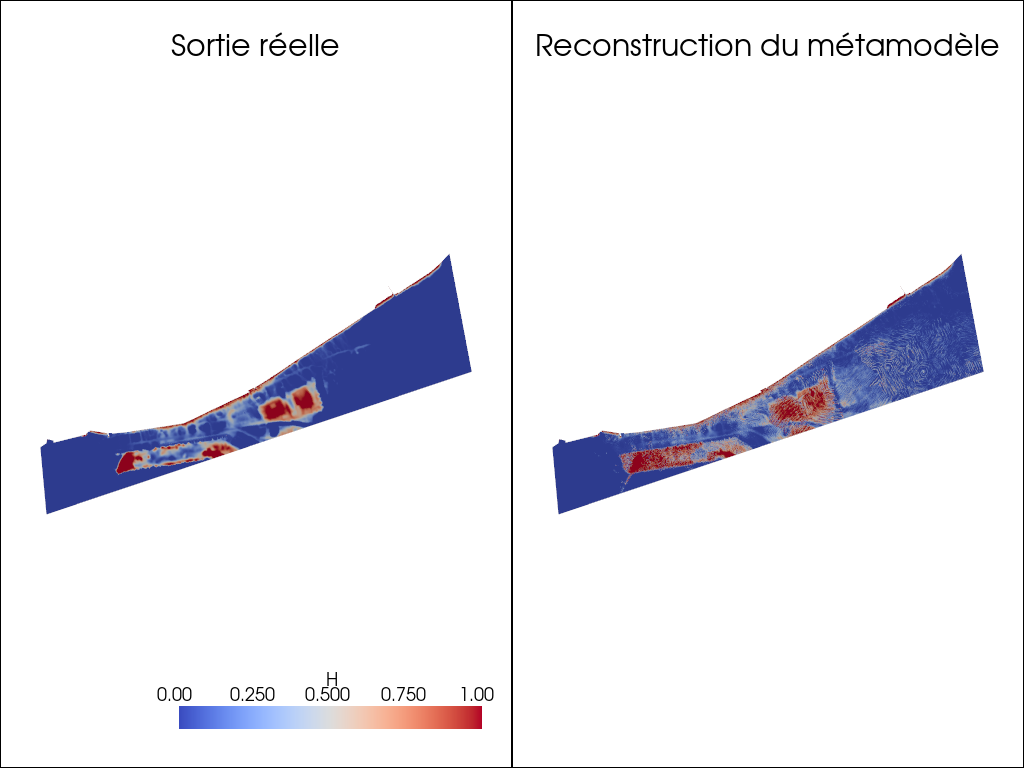

In [73]:
plot_map(y_test[0,:],Y_test_reconstruct_ACP_wave[0,:])

/home/slisse/.conda/envs/PIR/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


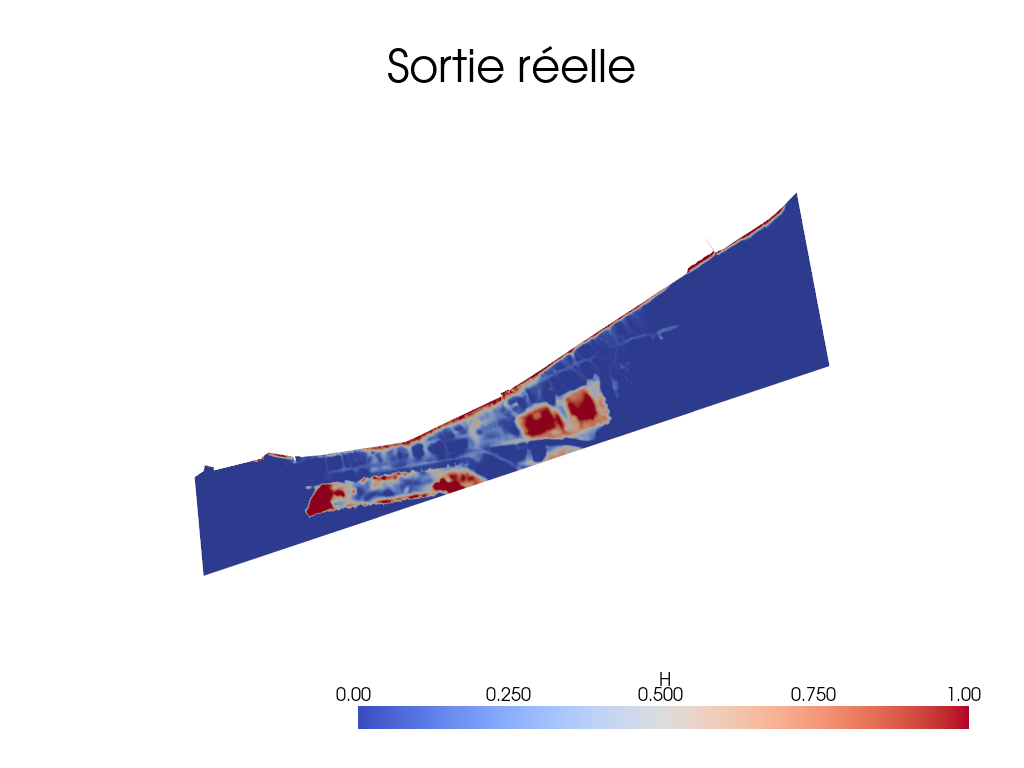

/home/slisse/.conda/envs/PIR/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


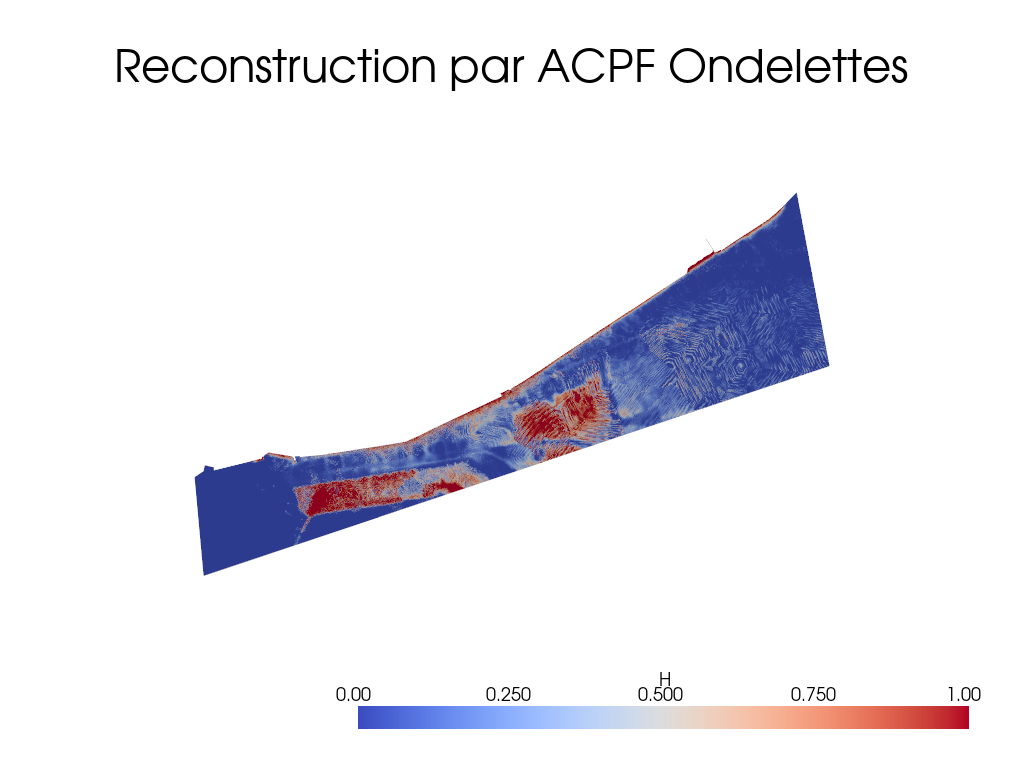

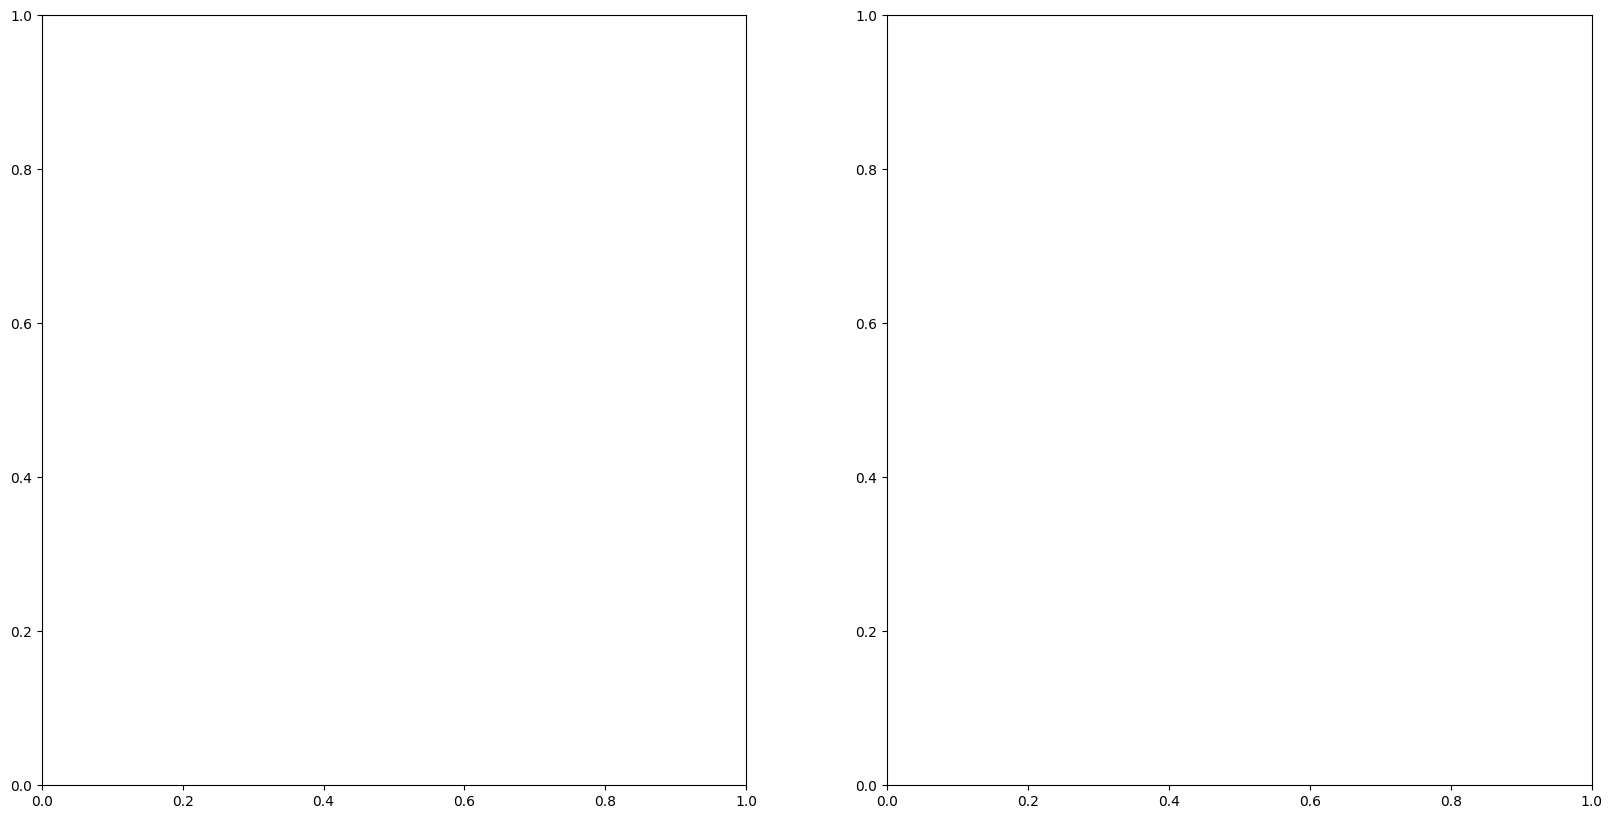

In [ ]:
plot_map(y_test[0,:], "Sortie réelle")
plot_map(Y_test_reconstruct_ACP_wave[0,:], "Reconstruction par ACPF Ondelettes")

### **(La suite est potentiellement à supprimer)**

In [ ]:
hs_list_test = np.arange(1, 3.1, 0.1)
msl_list_test = np.arange(0, 1.1, 0.05)
print(hs_list_test)
x_test=[]
for hs in hs_list_test:
    for msl in msl_list_test:
        x_test.append([hs,msl])
x_test=np.array(x_test)
print("taille de x_test:",x_test.shape)


[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3. ]
taille de x_test: (462, 2)


In [ ]:
Y_test_reconstruct_ACP = ACP.predict(x_test)

Prédiction en cours...


In [ ]:
print(Y_test_reconstruct_ACP.shape)

(462, 488290)
